In [274]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
le = LabelEncoder()
ss = StandardScaler()
import lazypredict
from lazypredict.Supervised import LazyClassifier

Exploring the Data:

In [275]:
# Import dataset
df = pd.read_csv('Datasets/bankdata.csv')

# Head of the dataset
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Features:
1. customer_id - The unique identifier for a particular customer.
2. credit_score - A measure of creditworthiness, how reliable a lender the customer is.
3. country - Country of residence for the customer.
4. gender - Gender of customer.
5. age - Age of customer.
6. tenure - Length of time the customer has held an account with the bank.
7. balance - Amount of money present in the customer's account.
8. products_number - The number of distinct products the customer holds with the bank (both a current account, isa, etc.)
9. credit_card - Does the customer possess a credit card with the bank? (1/0)
10. active_member - Is the customer actively using the bank's services?
11. estimated_salary - Estimated total income of the customer.
12. churn - Did the customer churn? (1/0) - Target Variable

Excluding customer_id, it appears we have 10 potential predictor variables that we can utilise in a model to predict the variable churn.

Descriptive Statistics:

In [276]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [277]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Through analysis of the descriptive statistics above, 20% of the customer pool of 10000 have churned. We also have no N/A variables so there is no need to clean data here or impute any variables.

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [279]:
# What countries are our customers from, and what's the exposure in said countries?
df.groupby('country')['customer_id'].count()

country
France     5014
Germany    2509
Spain      2477
Name: customer_id, dtype: int64

So we have data from 3 particular countries, with around 11 x 10000 = 110000 observations.

Exploratory Data Analysis:

In [280]:
# EDA

# What questions?
# What variable is most correlated to churn?
# Visually, what is the distribution of churn along various variables? e.g does it tend towards lower age, higher balance?

# We have no need for customer_id in our model, so this will be removed from the customer data set entirely, as opposed to churn which is only dropped from features
df.drop('customer_id', 1, inplace=True) # We don't want a copy so set inplace = True

array([[<AxesSubplot:title={'center':'credit_score'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tenure'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'products_number'}>,
        <AxesSubplot:title={'center':'credit_card'}>],
       [<AxesSubplot:title={'center':'active_member'}>,
        <AxesSubplot:title={'center':'estimated_salary'}>,
        <AxesSubplot:title={'center':'churn'}>]], dtype=object)

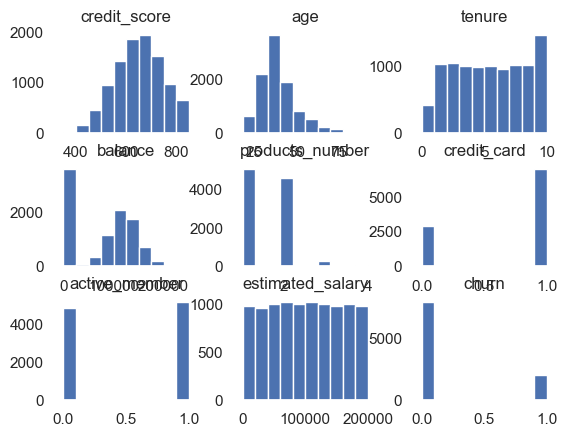

In [281]:
df.hist() # Quick visualisation of the distribution of variables in the dataset

From first glances at the histograms, we have large exposure at low balance, low estimated salary, high tenure and the age variable follows a normal distribution with mean at around 37.

In [282]:
# Create list of features
features = df.keys().drop('churn')
features

# Check central tendencies, grouped by churn, does anything jump out?
df.groupby('churn')[features].mean().style.background_gradient(cmap = "YlOrRd")

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
churn,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


We can see that those customers that churned tend to have (on average) marginally lower credit score, be of older age, hold more money in their accounts and be less active customers. It's important to note that since the mean is volatile to outliers, we should be aware that our data may has been skewed by outliers, moreso in the group where churn = 1 as the difference in exposures is rather large between these two groups (20% churned, 80% didn't). Following from that, lets use a measure of central tendency that is more robust to outliers, the median:

In [283]:
# Check central tendencies, grouped by churn, does anything jump out?
df.groupby('churn')[features].median().style.background_gradient(cmap = "YlOrRd")

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
churn,,,,,,,,
0,653.000000,36.000000,5.000000,92072.680000,2.000000,1.000000,1.000000,99645.040000
1,646.000000,45.000000,5.000000,109349.290000,1.000000,1.000000,0.000000,102460.840000


In this instance it appears that the median confirms the same conclusions as the mean, so there are not necessarily any particularly massive outliers. However, we can see that balance is skewed more towards lower income as the mean is quite a bit lower than the median here (high volume of lower incomes).

Churned: 2037
Retained: 7963


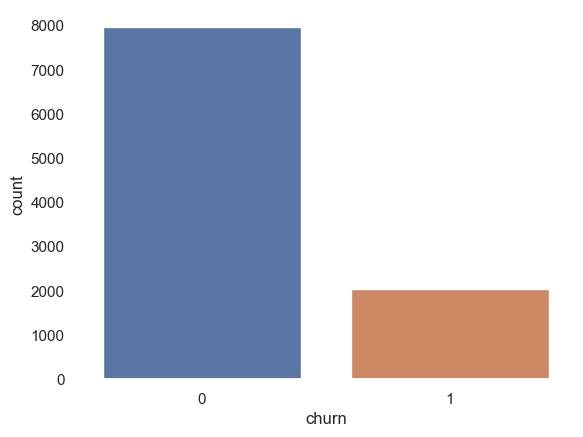

In [284]:
sns.countplot(df["churn"]) # Visualising the volume of customer churn
print("Churned:",df['churn'].sum())
print("Retained:",df['churn'].shape[0]-df['churn'].sum().sum())

<AxesSubplot:>

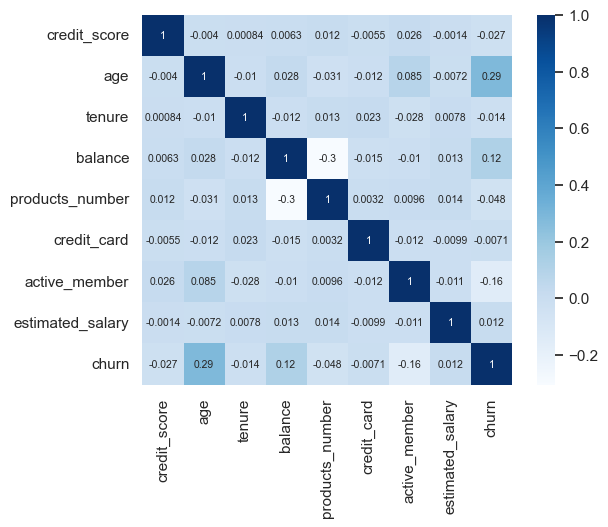

In [285]:
# Create a correlation matrix of all the elements, specifically to find out the highest correlation variable with churn.
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 7.5}, cmap='Blues', square=True)

Through the correlation matrix, we can see that age has the highest correlation with churn, with 0.29. The variable balance is also of interest, with a 0.12 correlation with churn. So older customers and those with higher balances are more likely to churn.

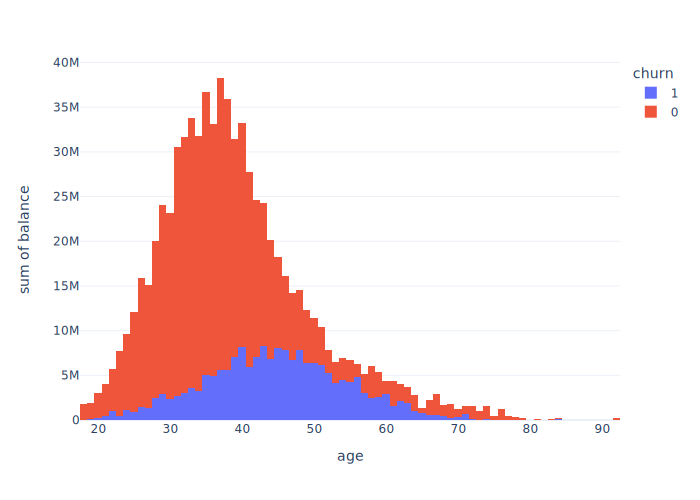

In [286]:
# Histogram of age v balance, for churn 1 and 0.
fig1 = px.histogram(df, x='age', y='balance', color='churn')
fig1.show()

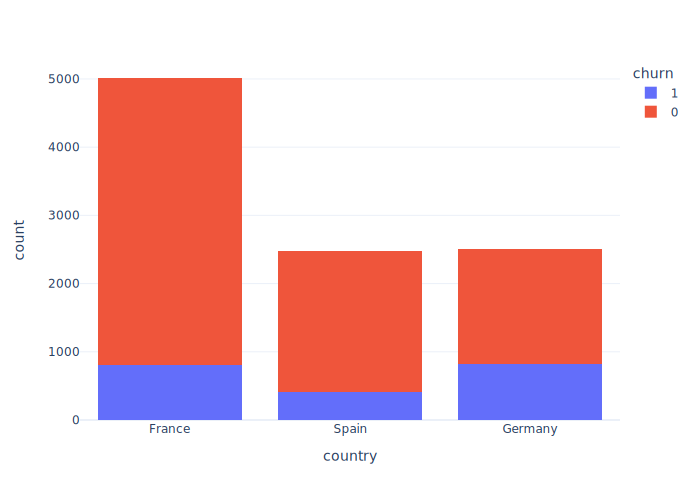

In [287]:
# Histogram for distribution of churn across countries in the data
fig2 = px.histogram(df, x='country', color = 'churn', barmode = 'stack')
fig2.show()

Whilst France sports the highest exposure of the 3 countries in the dataset, as a percentage of the population, French customers are less likely to churn and German customers are most likely. Spain is very close to France in terms of churn percentage but only marginally higher.

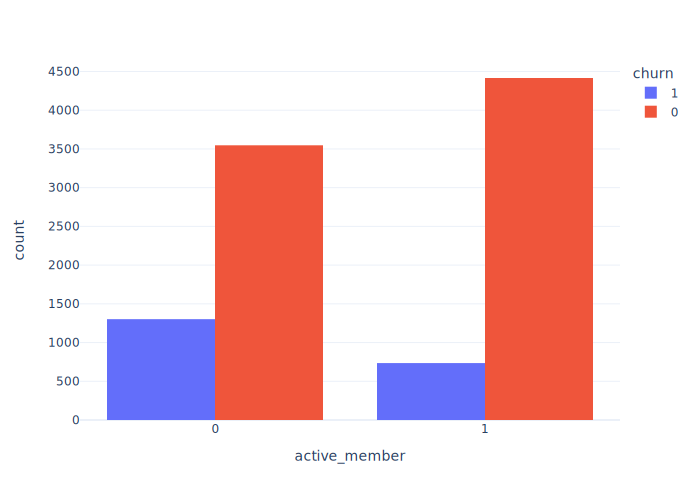

In [288]:
# Histogram for active member to see the exposure in churn 1 and 0.
fig2 = px.histogram(df, x='active_member', color = 'churn', barmode = 'group')
fig2.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))
fig2

It's visible through this histogram that despite the exposure being relatively similar between active_member groups 0 and 1, we see a larger churn count in active_member = 0.

The Model:

We can avoid the problem of having to choose the most accurate machine learning algorithm for classifying churn here by using the library LazyClassifier, which will quickly create models using varying Ml algorithms so that we can efficiently compare the accuracy of each model approach. LazyClassifier should also tune the parameters. Given that the percentage churn is 20% we'd hope to see around 80% accuracy from the best model here.

In [289]:
# Encode the categorical variables into numeric, so they can be inputted into the model
df['gender'] = le.fit_transform(df['gender'])
df['country'] = le.fit_transform(df['country'])

In [290]:
# Create train/test(validation) split to avoid bias in predictions
X = df.copy()
X.drop('churn', axis = 1, inplace=True) # Features
y = df['churn'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1999)

# We want to standardise/normalise our data for the features (mean = 0 and sd = 1) so that they are of similar scale
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [291]:
# Model
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, churnpredictions= model.fit(X_train_scaled, X_test_scaled, y_train, y_test)

100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


In [292]:
print(listofmodels)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.86               0.73     0.73      0.86   
RandomForestClassifier             0.86               0.71     0.71      0.85   
ExtraTreesClassifier               0.85               0.71     0.71      0.84   
AdaBoostClassifier                 0.85               0.71     0.71      0.84   
XGBClassifier                      0.85               0.71     0.71      0.84   
BaggingClassifier                  0.85               0.70     0.70      0.84   
NearestCentroid                    0.71               0.70     0.70      0.73   
DecisionTreeClassifier             0.80               0.69     0.69      0.80   
SVC                                0.85               0.68     0.68      0.83   
ExtraTreeClassifier                0.78               0.67     0.67      0.78   
LabelSpreading              

Model Evaluation:


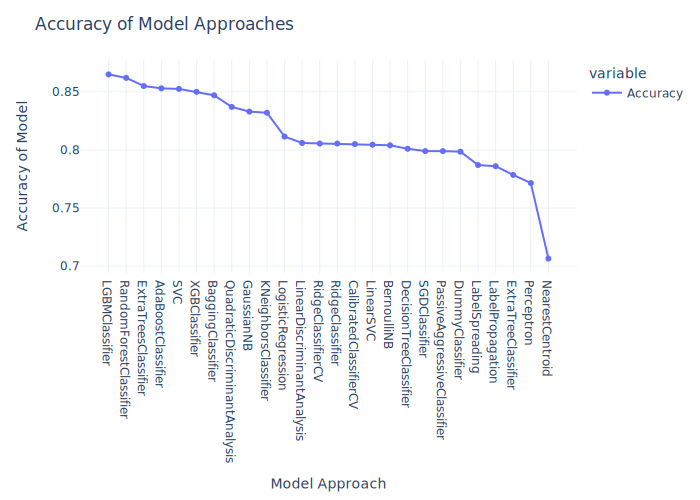

In [293]:
# Graph comparing accuracy of each model from LazyClassifier
listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(listofmodels, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()

It appears that the LightGBM (gradient boosting ensemble) and RandomForest approaches have produced the highest accuracy predictions here. They both had an accuracy of 86%.

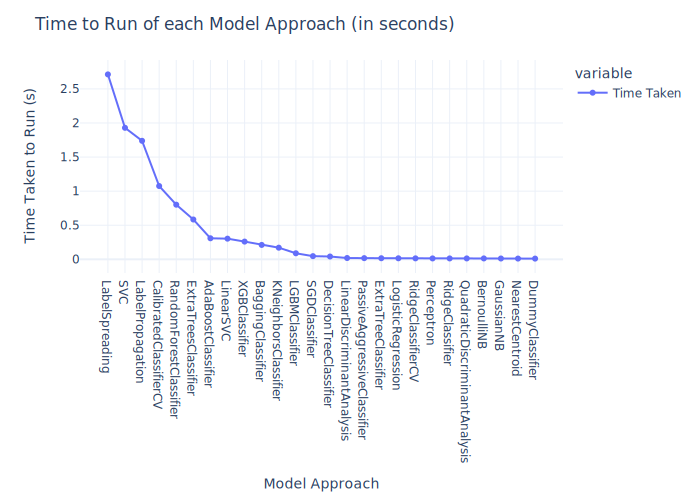

In [294]:
# Graph comparing time to evaluate using each model from LazyClassifier
listofmodels.sort_values('Time Taken', inplace = True, ascending = False)
graph2 = px.line(listofmodels, y =['Time Taken'], markers = True)
graph2.update_xaxes(title = 'Model Approach')
graph2.update_yaxes(title = 'Time Taken to Run (s)')
graph2.update_layout(title = 'Time to Run of each Model Approach (in seconds)', showlegend = True)
graph2.show()

Thanks for reading the notebook!